# Analiza danych z czujników

Ten notebook wczytuje dane z plików CSV wygenerowanych przez moduł loggera
i przeprowadza podstawową analizę oraz wizualizacje.

## Zawartość:
1. Ustawienie bieżącego katalogu (root projektu)
2. Wczytanie bibliotek i konfiguracja środowiska
3. Wczytanie listy plików CSV z folderu `logs/`
4. Połączenie wszystkich plików w jeden DataFrame
5. Przykładowa analiza: konwersja, czyszczenie, statystyki opisowe
6. Podstawowe statystyki opisowe dla każdej grupy sensorów
7. Wizualizacja odczytów w czasie
8. Obliczenie i wizualizacja średnich ruchomych (1h, 12h) dla temp1
9. Rysowanie oryginalnych odczytów oraz średnich ruchomych dla 'temp1'
10. Zapisanie oczyszczonego DataFrame do pliku CSV

In [85]:
# 1. Ustawienie bieżącego katalogu na katalog główny projektu
import os

print("Bieżący katalog:", os.getcwd())

# 2. Wczytanie bibliotek i konfiguracja środowiska
import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True


Bieżący katalog: C:\Users\Wiktor\Desktop\py2025-project-v1-131439


In [86]:
# 3. Wczytanie listy wszystkich plików CSV z folderu logs/
csv_files = glob.glob(os.path.join('logs', 'sensors_*.csv'))
print("Znalezione pliki CSV:", csv_files)



Znalezione pliki CSV: ['logs\\sensors_20250531.csv']


In [87]:
# 4. Połączenie wszystkich znalezionych plików w jeden DataFrame
dfs = []
for fname in csv_files:

    df = pd.read_csv(
        fname,
        header=None,
        names=['timestamp', 'sensor_id', 'value', 'unit'],

    )
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)
data.head()



,timestamp,sensor_id,value,unit
0,2025-05-31T21:30:53.319175,temp1,15.000000,?C
1,2025-05-31T21:30:53.319175,hum1,62.246091,%RH
2,2025-05-31T21:30:53.319175,pres1,972.380899,hPa
3,2025-05-31T21:30:53.319175,light1,0.000000,lx
4,2025-05-31T21:30:53.319175,airq1,0.634112,AQI


In [88]:
# 5. Konwersja i czyszczenie danych
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
data['value']     = pd.to_numeric(data['value'], errors='coerce')

data = data.dropna(subset=['timestamp', 'sensor_id', 'value', 'unit'])

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  100 non-null    datetime64[ns]
 1   sensor_id  100 non-null    object        
 2   value      100 non-null    float64       
 3   unit       100 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 3.3+ KB


In [89]:
# 6. Podstawowe statystyki opisowe dla każdej grupy sensorów
stats = data.groupby('sensor_id')['value'].describe()
stats

,count,mean,std,min,25%,50%,75%,max
sensor_id,,,,,,,,
airq1,20.0,235.315414,80.462182,0.634112,247.027347,251.329050,264.900742,296.745486
hum1,20.0,49.528336,28.649403,0.000000,31.419603,54.606732,68.375116,93.824521
light1,20.0,0.001633,0.001540,0.000000,0.000301,0.001197,0.002687,0.004773
pres1,20.0,995.306372,31.710293,955.116967,966.442008,992.009900,1020.486472,1048.803431
temp1,20.0,20.493091,3.398559,15.000000,17.767870,20.518350,23.234357,25.899025


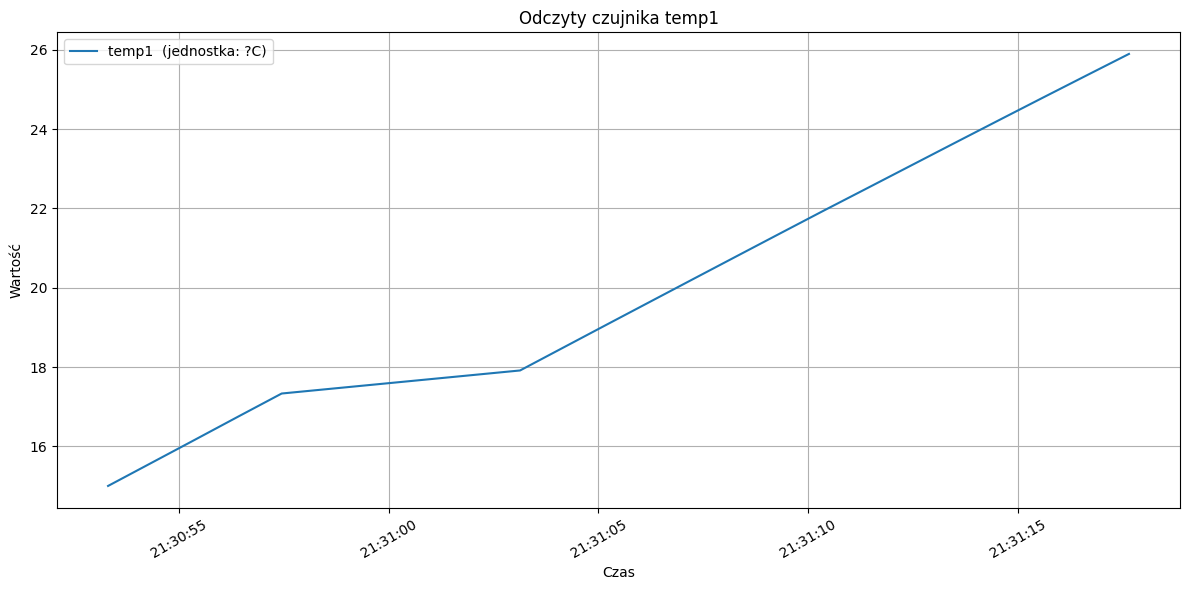

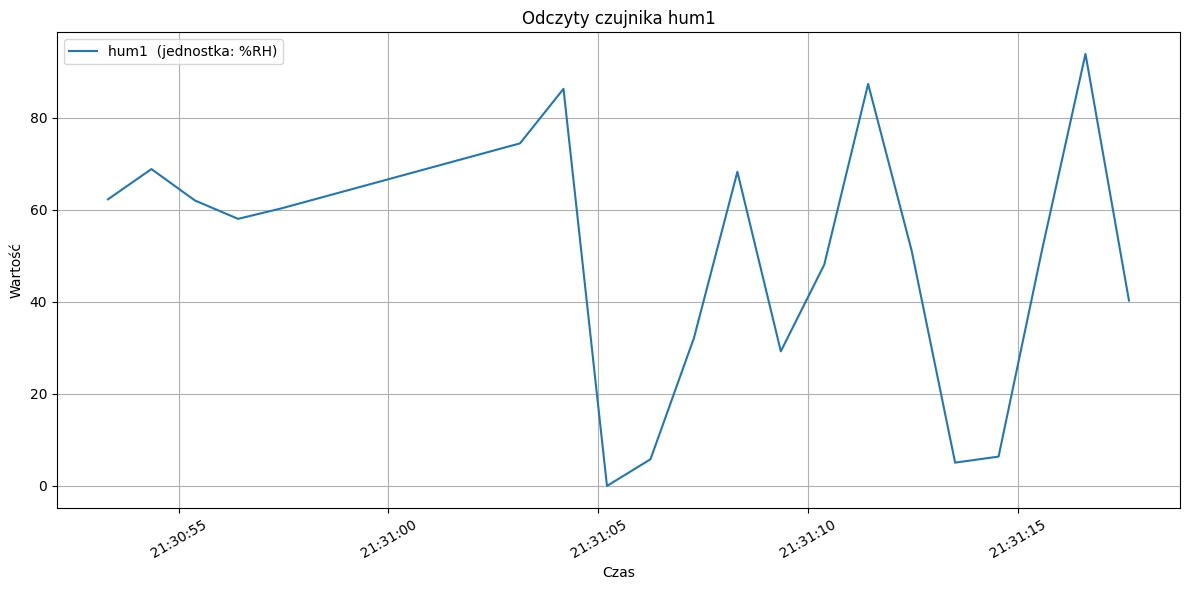

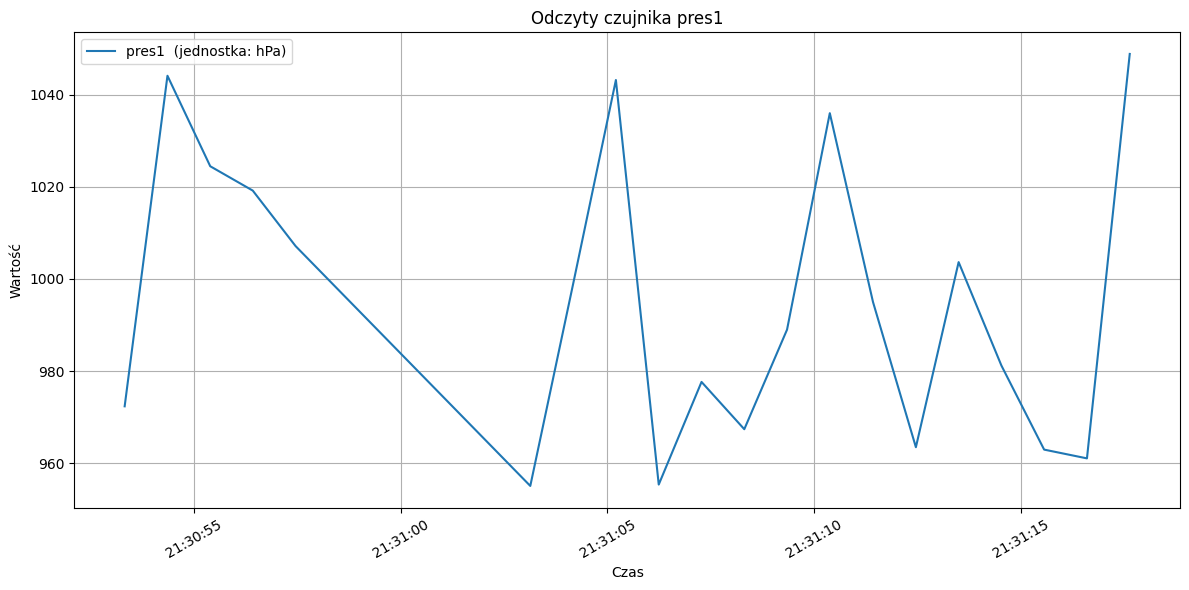

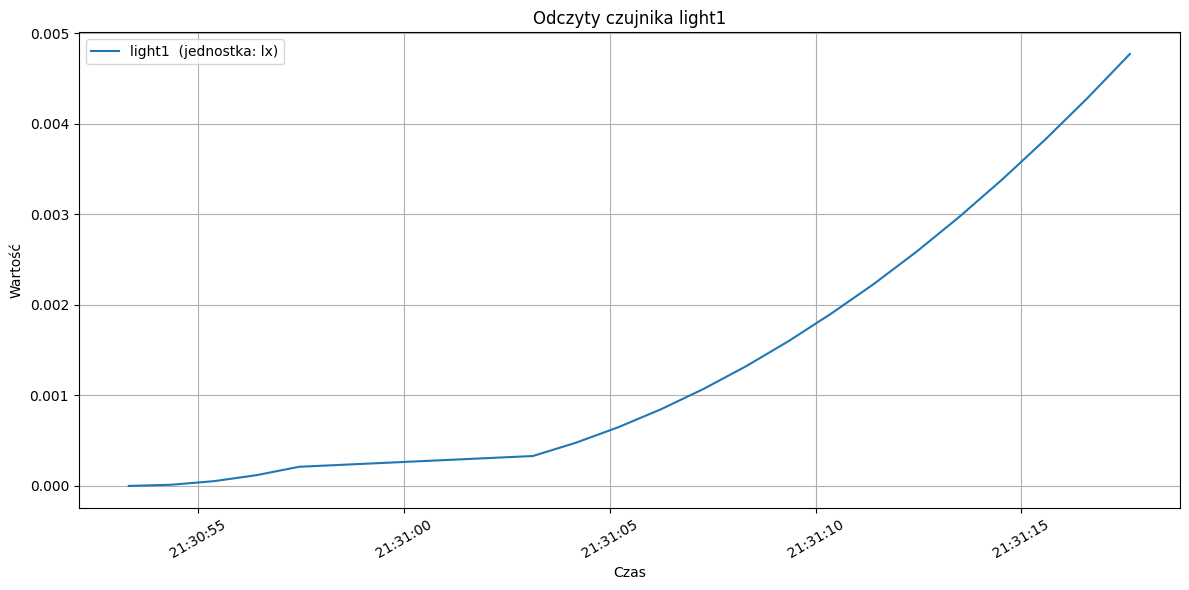

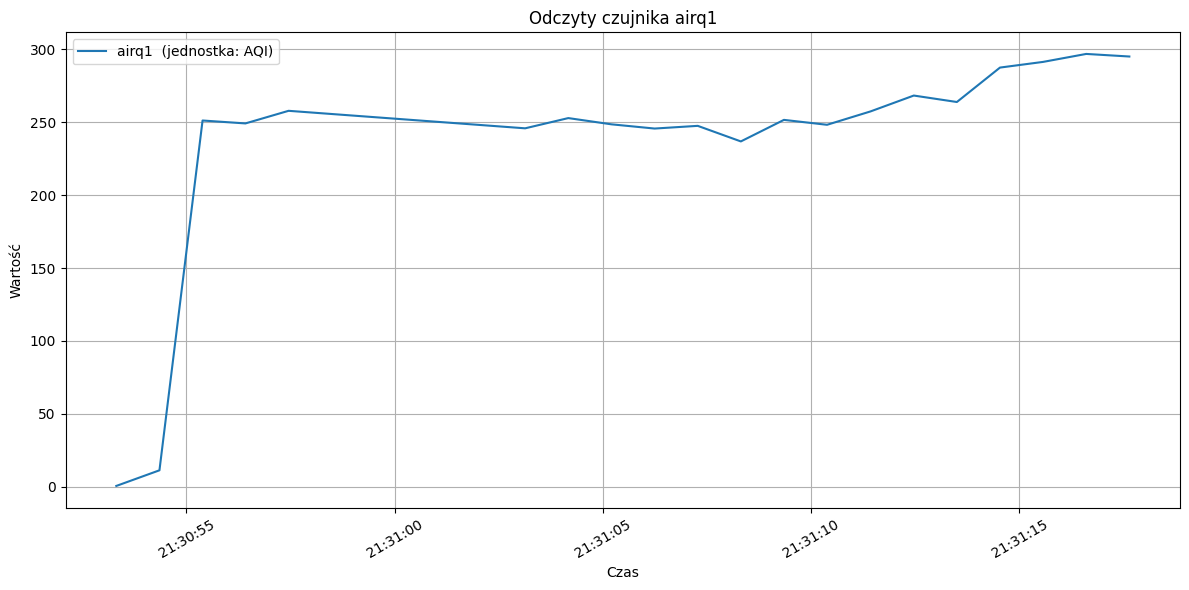

In [90]:
# 7. Wizualizacja odczytów w czasie dla każdego czujnika
sensor_ids = data['sensor_id'].unique()

for sid in sensor_ids:
    df_s = data[data['sensor_id'] == sid].sort_values('timestamp')
    plt.figure()
    plt.plot(
        df_s['timestamp'],
        df_s['value'],
        label=f'{sid}  (jednostka: {df_s["unit"].iloc[0]})',
        linewidth=1.5
    )
    plt.xlabel('Czas')
    plt.ylabel('Wartość')
    plt.title(f'Odczyty czujnika {sid}')
    plt.legend()
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


In [95]:
# 8. Obliczenie średnich ruchomych (1h i 12h) dla czujnika 'temp1'
sid = 'temp1'
df_temp = data[data['sensor_id'] == sid].sort_values('timestamp').set_index('timestamp')

df_temp_resampled = df_temp['value'].resample('1min').ffill().to_frame()

df_temp_resampled['rolling_1h']  = df_temp_resampled['value'].rolling(window=60).mean()
df_temp_resampled['rolling_12h'] = df_temp_resampled['value'].rolling(window=720).mean()

df_temp_resampled.head()


,value,rolling_1h,rolling_12h
timestamp,,,
2025-05-31 21:30:00,NaN,NaN,NaN
2025-05-31 21:31:00,17.331605,NaN,NaN


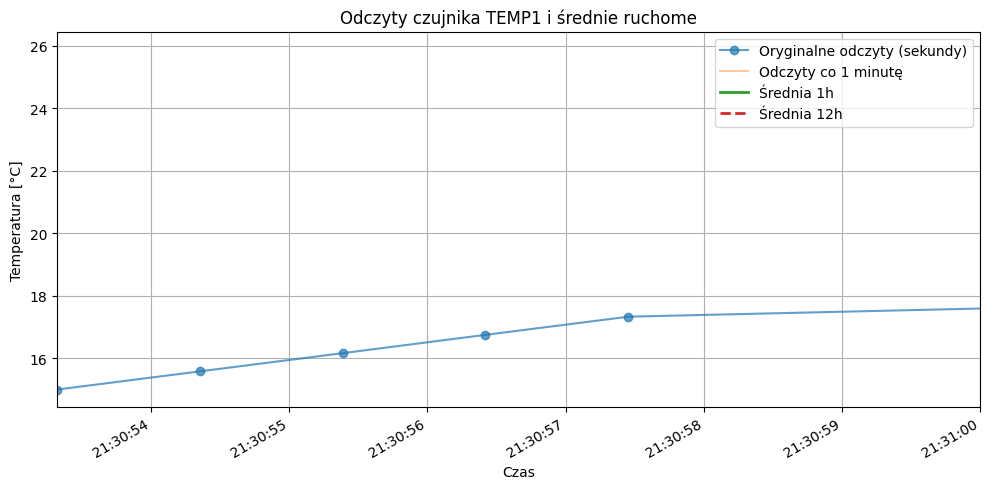

In [96]:
# 9. Rysowanie oryginalnych odczytów oraz średnich ruchomych dla 'temp1'

plt.figure(figsize=(10, 5))

plt.plot(
    df_temp.index,
    df_temp['value'],
    marker='o',
    linestyle='-',
    label='Oryginalne odczyty (sekundy)',
    alpha=0.7
)

plt.plot(
    df_temp_resampled.index,
    df_temp_resampled['value'],
    linestyle='-',
    alpha=0.4,
    label='Odczyty co 1 minutę'
)

plt.plot(
    df_temp_resampled.index,
    df_temp_resampled['rolling_1h'],
    label='Średnia 1h',
    linewidth=2
)

plt.plot(
    df_temp_resampled.index,
    df_temp_resampled['rolling_12h'],
    label='Średnia 12h',
    linestyle='--',
    linewidth=2
)

plt.xlabel('Czas')
plt.ylabel('Temperatura [°C]')
plt.title('Odczyty czujnika TEMP1 i średnie ruchome')
plt.legend()

min_date = df_temp.index.min()
max_date = df_temp_resampled.index.max()
plt.xlim(min_date, max_date)

plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()



In [97]:
# 10. Zapisanie oczyszczonego DataFrame do pliku CSV
output_path = 'analysis/cleaned_sensor_data.csv'
data.to_csv(output_path, index=False)
print(f'Oczyszczone dane zapisane do: {output_path}')


Oczyszczone dane zapisane do: analysis/cleaned_sensor_data.csv
